### Imports and sanity check

In [2]:
# import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Subset
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import os
import numpy 
import gdown
import zipfile
import random
import shutil

The below code should fetch the folder from google drive and extract the images into a folder in the input

In [ ]:
# if not os.path.exists("../input/train_images_5_class"):
#     os.makedirs("../input/train_images_5_class")
#     output_path = "../input/train_images_5_class.zip"
#     gdown.download(f"https://drive.google.com/uc?id=1EfxHr8S4llUwu8P36Frq3h6XSBzrsHvp", output_path, quiet=False)
#     with zipfile.ZipFile(output_path, 'r') as zip_ref:
#         zip_ref.extractall("../input")

Downloading...
From (original): https://drive.google.com/uc?id=1EfxHr8S4llUwu8P36Frq3h6XSBzrsHvp
From (redirected): https://drive.google.com/uc?id=1EfxHr8S4llUwu8P36Frq3h6XSBzrsHvp&confirm=t&uuid=56eb3859-3c3a-47ed-b04f-afb9b999c27c
To: c:\Users\yongl\OneDrive\Documents\GitHub\DogEmotionADL\input\train_images_5_class.zip
100%|██████████| 232M/232M [00:41<00:00, 5.60MB/s] 


The below should do the same except that it is for the processed images from billy's code

In [3]:
if not os.path.exists("../input/final_split"):
    # os.makedirs("../input/actual")
    output_path = "../input/final_split.zip"
    gdown.download(f"https://drive.google.com/uc?id=11t8m703wcNss3w5diJSUGBA_vXnCKChr", output_path, quiet=False)
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        zip_ref.extractall("../input")

Downloading...
From (original): https://drive.google.com/uc?id=11t8m703wcNss3w5diJSUGBA_vXnCKChr
From (redirected): https://drive.google.com/uc?id=11t8m703wcNss3w5diJSUGBA_vXnCKChr&confirm=t&uuid=5d4bf77a-87d9-43b9-a1ff-4a7c74eb2596
To: /Users/valencia/Desktop/vscode_projects/adl_dog/DogEmotionADL/input/final_split.zip
100%|██████████| 95.8M/95.8M [00:01<00:00, 66.8MB/s]


### Making sure EfficientNetCanBeLoaded

In [5]:
rootPath = "../input"
data_dir = rootPath + "/train_images_4_class"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),         
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check classes
print("Classes:", dataset.classes)


Classes: ['angry', 'happy', 'relaxed', 'sad']


c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


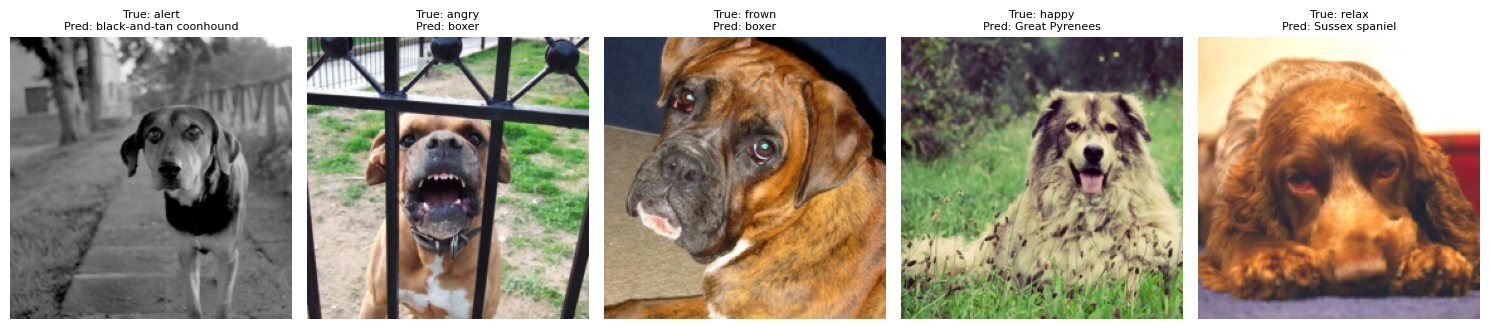

In [4]:
## DO NOT touch this, seems to have a bug with the version of torchvision so need this to download the weights
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b5(weights=EfficientNet_B5_Weights.IMAGENET1K_V1)
model = efficientnet_b5(weights="DEFAULT")
model.eval() 
######

rootPath = "../input"
data_dir = rootPath + "/train_images_5_class"


# Do note that efficientnet is 456, so maybe we should be upscaling?
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

first_images = {}
class_names = dataset.classes

for img, label in dataset:
    class_name = class_names[label]
    if class_name not in first_images:
        first_images[class_name] = img
    if len(first_images) == len(class_names):
        break

weights = EfficientNet_B5_Weights.DEFAULT
preprocess = weights.transforms()

plt.figure(figsize=(15, 5))
for idx, (class_name, image) in enumerate(first_images.items()):
    plt.subplot(1, len(first_images), idx + 1)

    input_tensor = preprocess(image).unsqueeze(0)  

    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        pred_label = weights.meta["categories"][pred_idx]

    # Show image with prediction
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"True: {class_name}\nPred: {pred_label}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Data Splitting ( No longer in use)
From the folder of alert, angry, frown, happy and relax
Split the data into three folders of train, eval and test for the sake of reproducibility

Assummes the data is already in the input folder under train_images_5_class

In [ ]:
# def splitDataIntoSub(root ="../input/train_images_4_class", properSubfolder="actual", ratio = [0.7,0.15, 0.15]):
#     if os.path.exists(f"../input/{properSubfolder}"):
#         shutil.rmtree(f"../input/{properSubfolder}")
#     if os.path.exists(root):
#         trainRoot = f"../input/{properSubfolder}/train"
#         if not os.path.exists(trainRoot):
#             os.makedirs(trainRoot)
#         evalRoot = f"../input/{properSubfolder}/eval"
#         if not os.path.exists(evalRoot):
#             os.makedirs(evalRoot)
#         testRoot = f"../input/{properSubfolder}/test"
#         if not os.path.exists(testRoot):
#             os.makedirs(testRoot)
#         for subDirectory in (os.listdir(root)):
#             print("----------------")
#             print(subDirectory)
#             classPath = os.path.join(root, subDirectory)
#             if not os.path.isdir(classPath):
#                 continue
#             images = os.listdir(classPath)
#             random.shuffle(images)
            
#             total = len(images)
#             trainEnd = int(ratio[0] * total)
#             evalEnd = trainEnd + int(ratio[1] *total)

#             splitImages = {
#                 "train": images[:trainEnd],
#                 "eval": images[trainEnd:evalEnd],
#                 "test": images[evalEnd:]
#             }
#             print(list((key, len(item)) for key, item in splitImages.items()))

#             for split in splitImages:
#                 splitDir = os.path.join("../input/", properSubfolder, split, subDirectory)
#                 os.makedirs(splitDir, exist_ok=True)

#                 for img_file in splitImages[split]:
#                     src = os.path.join(root, subDirectory, img_file)
#                     dst = os.path.join(splitDir, img_file)
#                     shutil.copy2(src, dst)         
#     else:
#         print("Data does not exists")

# splitDataIntoSub()

----------------
angry
[('train', 1967), ('eval', 421), ('test', 423)]
----------------
happy
[('train', 2081), ('eval', 445), ('test', 447)]
----------------
relaxed
[('train', 2051), ('eval', 439), ('test', 441)]
----------------
sad
[('train', 1934), ('eval', 414), ('test', 415)]


### Valid data in folder

In [8]:
def checkfolder(root="../input", actualFolder ="actual"):
    folder = os.path.join(root, actualFolder)
    if (os.path.exists(folder)):
        for sub in os.listdir(folder):
            print("------------")
            print(sub)
            subFolder = os.path.join(folder, sub)
            for emotion in os.listdir(subFolder):
                subFolderEmotion = os.path.join(subFolder, emotion)
                print(len(os.listdir(subFolderEmotion)))
                

checkfolder()

------------
eval
421
445
439
414
------------
test
423
447
441
415
------------
train
1967
2081
2051
1934
